In [1]:
!pip install 'kaggle-environments>=0.1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from kaggle_environments import evaluate, make
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

Loading environment lux_ai_s2 failed: No module named 'vec_noise'


In [3]:
class Agent():
  def __init__(self, input_shape, actions):
    self.input_shape = input_shape
    self.actions = actions
    self.epsilon = 1
    self.epsilon_decay = 0.995
    self.learning_rate = 0.0001
    self.build_model()

  def build_model(self):
    self.model = Sequential()
    self.model.add(Input((self.input_shape)))
    self.model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    self.model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    self.model.add(Flatten())
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dense(128, activation='relu'))
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dense(self.actions, activation='linear'))
    self.model.summary()

  def action(self, observation):
    obs = np.array(observation)
    obs = obs.reshape(obs.shape[0], self.input_shape[0],self.input_shape[1],self.input_shape[2])
    if np.random.rand() <= self.epsilon:
      return random.choice([0, 1, 2, 3, 4, 5, 6])
    else:
      preds = self.model.predict(obs, verbose=-1)
      return np.max(preds)

  def my_agent(self, observation, configuration):
    preds = self.model.predict(np.array([observation['board']]).reshape(1, 6, 7, 1), verbose=-1)
    return int(np.max(preds))

  def clear_(self):
    self.obs = []
    self.actions = []
    self.rewards = []
    self.next = []

  def train(self):
    optimizer = tf.keras.optimizers.Adam()
    with tf.GradientTape() as tape:
      obs = np.array(self.obs)
      obs = obs.reshape(obs.shape[0], self.input_shape[0],self.input_shape[1],self.input_shape[2])
      logits = self.model(obs)
      softmax_cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.actions)
      loss = tf.reduce_mean(softmax_cross_entropy + self.rewards)
      grads = tape.gradient(loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
      if self.epsilon > 0.01:
        self.epsilon *= self.epsilon_decay

  def save(self, observation, action, reward, new_obs, state):
    self.obs.append(np.array([observation]))
    self.actions.append(action)
    self.rewards.append(reward)
    self.next.append(np.array([new_obs]))

In [4]:
class Connect4():
  def __init__(self):
    self.env = make("connectx", debug=True)
    self.env.render()
    self.env.reset

  def run(self, agent):
    self.env.reset()
    self.env.run([agent.my_agent, 'random'])
    self.env.render(mode="ipython", width=500, height=450)

  def reset_(self):
    return self.train.reset()['board']

  def train_(self, pair):
    self.train = self.env.train(pair)

  def step_(self, action):
    return self.train.step(action)

  def get_reward(self, state, winner):
    reward = 0
    if not state:
      reward = -1
    if state: 
      if winner == 1:
        reward = 50
      if winner == -1:
        reward = -50
      if winner == 0:
        reward = -50
    return reward
  
  def check_action(self, action, observation):
    while action > 6 or action < 0:
      action = random.choice([0, 1, 2, 3, 4, 5, 6])
    while observation[action] != 0:
      action = random.choice([0, 1, 2, 3, 4, 5, 6])
    return action

In [5]:
episode = 1000
agent = Agent((6, 7, 1), 7)
env_ = Connect4()
pair = [None, 'random']
all_reward = []
avg_reward = []
win = 0
wins = []
for e in range(episode):
  agent.clear_()
  env_.train_(pair)
  observation = env_.reset_()
  state = False
  tot_reward = 0
  while not state:
    action = int(agent.action([observation]))
    action = env_.check_action(action, observation)
    new_obs, winner, state, info = env_.step_(action)
    reward = env_.get_reward(state, winner)
    tot_reward += reward
    agent.save(observation, action, tot_reward, new_obs['board'], state)
    observation = new_obs['board']
  if winner == 1:
    win += 1
  wins.append(win/(e+1))
  all_reward.append(tot_reward)
  avg_reward.append(sum(all_reward) / len(all_reward))
  agent.train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 7, 64)          1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 7, 64)          16448     
                                                                 
 flatten (Flatten)           (None, 2688)              0         
                                                                 
 dense (Dense)               (None, 64)                172096    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 7)                 4

In [ ]:
episode = 1000
env = Connect4()
pair = [None, 'random']
all_reward_random = []
avg_reward_random = []
win_random = 0
wins_random = []
for e in range(episode):
  env.train_(pair)
  observation = env.reset_()
  state = False
  tot_reward_random = 0
  while not state:
    action = random.choice([0, 1, 2, 3, 4, 5, 6])
    new_obs, winner, state, info = env.step_(action)
    reward_random = env.get_reward(state, winner)
    tot_reward_random += reward_random
    observation = new_obs['board']
  if winner == 1:
    win_random += 1
  wins_random.append(win_random/(e+1))
  all_reward_random.append(tot_reward_random)
  avg_reward_random.append(sum(all_reward_random) / len(all_reward_random))

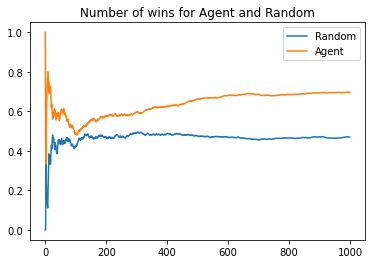

In [7]:
plt.plot(wins_random)
plt.plot(wins)
plt.legend(['Random', 'Agent'])
plt.title('Number of wins for Agent and Random')
plt.show()

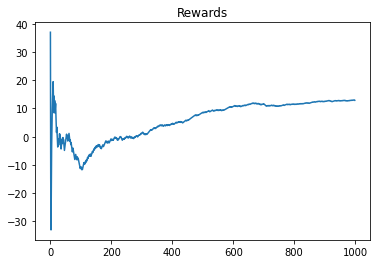

In [8]:
plt.plot(avg_reward)
plt.title('Rewards')
plt.show()

In [21]:
env_.run(agent)